<a href="https://colab.research.google.com/github/gnbhub/gnb_2022_1_Ai_team1/blob/master/Week7/%EC%98%81%ED%99%94%EA%B4%80%EA%B0%9D%EC%88%98_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [163]:
import pandas as pd
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
train=pd.read_csv('/content/movies_train.csv')
test=pd.read_csv('/content/movies_test.csv')
submission=pd.read_csv('/content/submission.csv')

In [164]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [165]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [166]:
test.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1


In [167]:
submission.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


In [168]:
#결측치 많은 데이터 제거
train=train.drop(['dir_prev_bfnum'],axis=1)
test=test.drop(['dir_prev_bfnum'],axis=1)

In [169]:
# 제목 : 의미가 없기 때문에 제거
train = train.drop(['title'],axis= 1)
test = test.drop(['title'],axis= 1)

In [170]:
#감독명:다양해서 제거
train=train.drop(['director'],axis=1)
test=test.drop(['director'],axis=1)

In [171]:
train.distributor.value_counts()

CJ 엔터테인먼트        54
롯데엔터테인먼트         52
(주)NEW           30
(주)마운틴픽쳐스        29
(주)쇼박스           26
                 ..
OAL(올)            1
(주)에이원 엔터테인먼트     1
(주)콘텐츠 윙          1
위더스필름             1
퍼스트런              1
Name: distributor, Length: 169, dtype: int64

In [172]:
# 상위 5개의 배급사를 제외하고 '기타'로처리
distributor_list = train.distributor.value_counts()[:5]
def func(distributor):
    if distributor in distributor_list:
        return distributor
    else:
        return '기타'

train['distributor'] = train['distributor'].apply(lambda x : func(x))
test['distributor'] = test['distributor'].apply(lambda x : func(x))


In [173]:
train.describe(include='all')

,distributor,genre,release_time,time,screening_rat,dir_prev_num,num_staff,num_actor,box_off_num
count,600,600,600,600.000000,600,600.000000,600.000000,600.000000,6.000000e+02
unique,6,12,330,NaN,4,NaN,NaN,NaN,NaN
top,기타,드라마,2015-10-22,NaN,청소년 관람불가,NaN,NaN,NaN,NaN
freq,409,221,6,NaN,204,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,100.863333,NaN,0.876667,151.118333,3.706667,7.081818e+05
std,NaN,NaN,NaN,18.097528,NaN,1.183409,165.654671,2.446889,1.828006e+06
min,NaN,NaN,NaN,45.000000,NaN,0.000000,0.000000,0.000000,1.000000e+00
25%,NaN,NaN,NaN,89.000000,NaN,0.000000,17.000000,2.000000,1.297250e+03
50%,NaN,NaN,NaN,100.000000,NaN,0.000000,82.500000,3.000000,1.259100e+04
75%,NaN,NaN,NaN,114.000000,NaN,2.000000,264.000000,4.000000,4.798868e+05


<function matplotlib.pyplot.show>

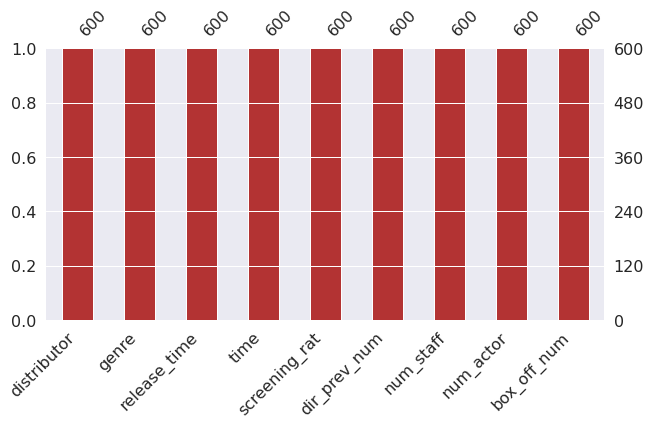

In [174]:
import missingno as msno
msno.bar(train,figsize=(10,5),color=(0.7,0.2,0.2))
plt.show

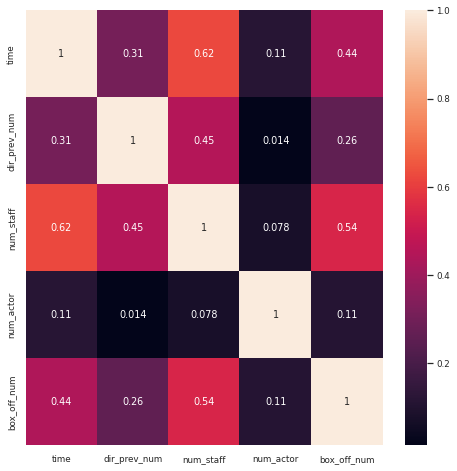

In [175]:
plt.figure(figsize=(8,8))
sns.set(font_scale=0.8)
sns.heatmap(train.corr(),annot=True, cbar=True);
plt.show()

In [176]:
corr_mat=train.corr()
corr_mat['box_off_num'].sort_values(ascending=False)

box_off_num     1.000000
num_staff       0.544265
time            0.441452
dir_prev_num    0.259674
num_actor       0.111179
Name: box_off_num, dtype: float64

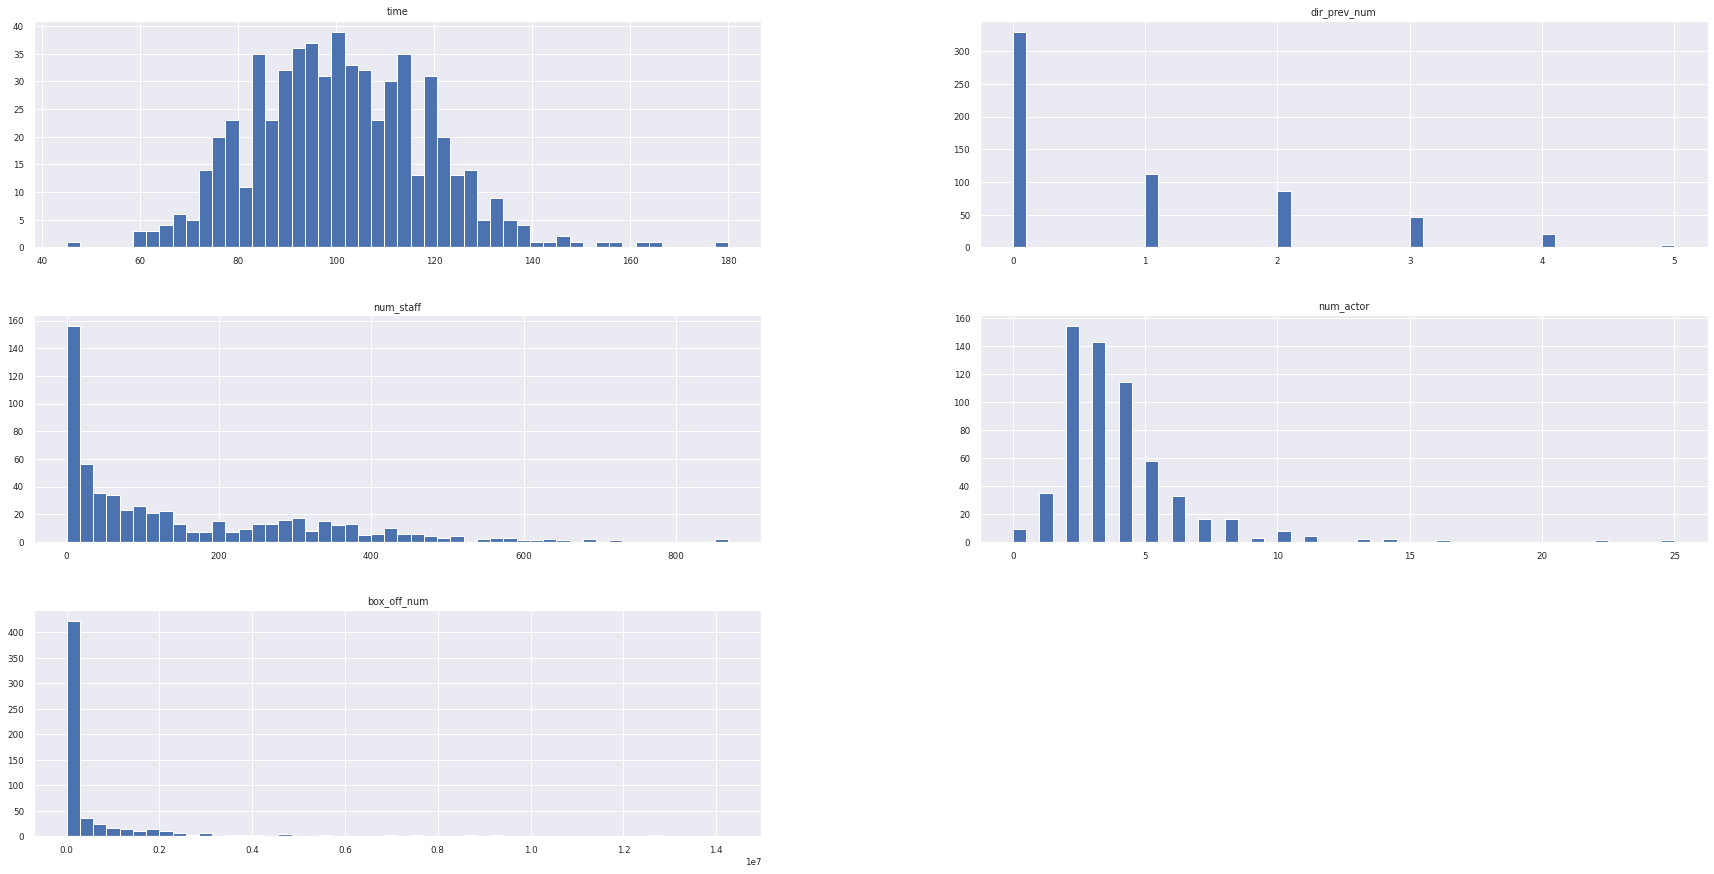

In [177]:
import matplotlib.pyplot as plt
%matplotlib inline
train.hist(bins=50, figsize=(30,15))
plt.show()

In [178]:
from sklearn.model_selection import train_test_split

X_data = train.loc[:,['time','num_staff','dir_prev_num']]
y_data = train.loc[:,'box_off_num']

X_train, X_test, y_train, y_test = train_test_split(X_data,y_data,test_size=0.2,shuffle=True,random_state=12)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(480, 3) (480,)
(120, 3) (120,)


In [183]:
#랜덤포레스트
from sklearn.tree import DecisionTreeRegressor
rfr = DecisionTreeRegressor(max_depth=4, random_state=12)
rfr.fit(X_train, y_train)
y_train_pred= rfr.predict(X_train)

y_test_pred=rfr.predict(X_test)
